In [128]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

In [156]:
# Paths
DATASET_DIR = "captcha_data"

# Image parameters (paper-like)
IMG_HEIGHT = 50
IMG_WIDTH = 200
CHANNELS = 1

# CAPTCHA parameters
CAPTCHA_LENGTH = 5
CHARSET = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
NUM_CLASSES = len(CHARSET)

# Training
BATCH_SIZE = 64
EPOCHS = 15
LR = 1e-3
if torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print("Using device:", DEVICE)

Using device: mps


In [142]:
char2idx = {c: i for i, c in enumerate(CHARSET)}
idx2char = {i: c for c, i in char2idx.items()}

In [143]:
def encode_label(text):
    return [char2idx[c] for c in text]

def decode_label(indices):
    return "".join([idx2char[i] for i in indices])

In [144]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)

    if img is None:
        raise ValueError(f"Unreadable image: {img_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)

    return img

In [145]:
class CaptchaDataset(Dataset):
    def __init__(self, image_files):
        self.image_files = image_files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]

        try:
            image = preprocess_image(img_path)
        except:
            return self.__getitem__((idx + 1) % len(self.image_files))

        label_text = os.path.basename(img_path).split(".")[0].upper()

        if len(label_text) != CAPTCHA_LENGTH:
            return self.__getitem__((idx + 1) % len(self.image_files))

        label = encode_label(label_text)

        return torch.tensor(image), torch.tensor(label)

In [134]:
bad_images = []

for img_path in all_images:
    img = cv2.imread(img_path)
    if img is None:
        bad_images.append(img_path)

print("Bad images found:", len(bad_images))

Bad images found: 0


In [135]:
for img in bad_images:
    os.remove(img)

In [146]:
all_images = [
    os.path.join(DATASET_DIR, f)
    for f in os.listdir(DATASET_DIR)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
]

train_imgs, val_imgs = train_test_split(
    all_images, test_size=0.1, random_state=42
)

train_ds = CaptchaDataset(train_imgs)
val_ds = CaptchaDataset(val_imgs)

train_loader = DataLoader(
    CaptchaDataset(train_imgs),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False
)

val_loader = DataLoader(
    CaptchaDataset(val_imgs),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

In [157]:
class CNNLSTM(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),
            nn.Dropout2d(0.1),
        )

        self.lstm = nn.LSTM(
            input_size=128 * (IMG_HEIGHT // 8),
            hidden_size=256,
            num_layers=2,
            bidirectional=True,
            batch_first=True
        )

        self.fc = nn.Linear(512, NUM_CLASSES)

    def forward(self, x):
        x = self.cnn(x)
        b, c, h, w = x.size()

        x = x.permute(0, 3, 1, 2)   # (B, W, C, H)
        x = x.reshape(b, w, c * h)

        x, _ = self.lstm(x)
        x = self.fc(x)

        return x

In [158]:
model = CNNLSTM().to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=2,
)

In [159]:
def evaluate(model, loader):
    model.eval()
    char_correct = 0
    char_total = 0
    captcha_correct = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(imgs)
            outputs = outputs[:, :CAPTCHA_LENGTH, :]

            preds = outputs.argmax(dim=2)

            char_correct += (preds == labels).sum().item()
            char_total += labels.numel()

            captcha_correct += (preds == labels).all(dim=1).sum().item()

    return char_correct / char_total, captcha_correct / len(loader.dataset)

In [ ]:
train_losses = []
val_char_acc = []
val_captcha_acc = []

best_captcha_acc = 0.0

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)[:, :CAPTCHA_LENGTH, :]

        loss = sum(
            criterion(outputs[:, i, :], labels[:, i])
            for i in range(CAPTCHA_LENGTH)
        ) / CAPTCHA_LENGTH

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    char_acc, captcha_acc = evaluate(model, val_loader)

    scheduler.step(captcha_acc)

    train_losses.append(epoch_loss / len(train_loader))
    val_char_acc.append(char_acc)
    val_captcha_acc.append(captcha_acc)

    if captcha_acc > best_captcha_acc:
        best_captcha_acc = captcha_acc
        torch.save(model.state_dict(), "best_cnn_lstm_captcha.pth")
        print("✅ Best model saved")

    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Loss: {train_losses[-1]:.4f} | "
        f"Char Acc: {char_acc:.4f} | "
        f"Captcha Acc: {captcha_acc:.4f}"
    )

100%|███████████████████████████████████████████████████████████████████████████████| 1158/1158 [02:05<00:00,  9.23it/s]


✅ Best model saved
Epoch 1/15 | Loss: 2.0083 | Char Acc: 0.8821 | Captcha Acc: 0.5440


100%|███████████████████████████████████████████████████████████████████████████████| 1158/1158 [02:09<00:00,  8.96it/s]


✅ Best model saved
Epoch 2/15 | Loss: 0.2297 | Char Acc: 0.9675 | Captcha Acc: 0.8530


 16%|████████████▊                                                                   | 185/1158 [00:19<01:44,  9.28it/s]

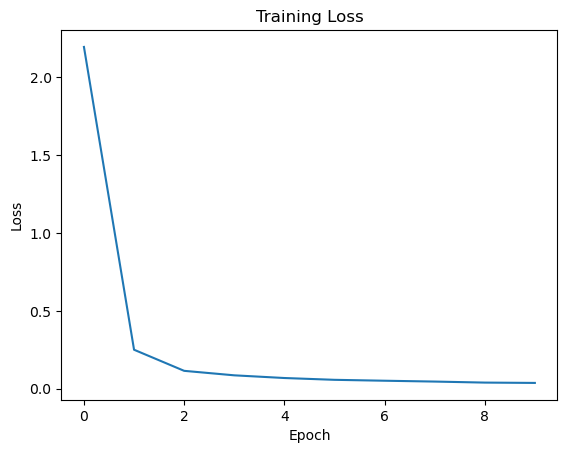

In [152]:
plt.figure()
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

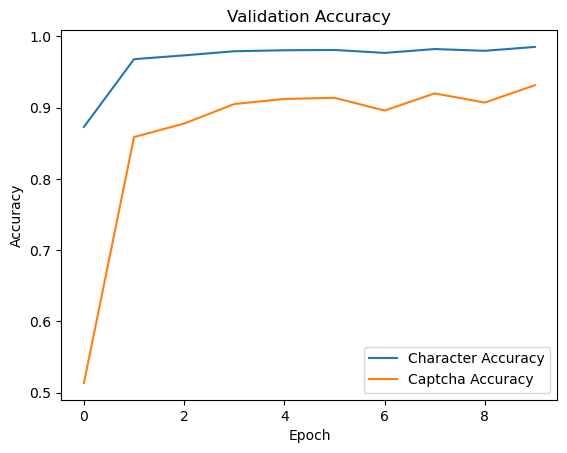

In [153]:
plt.figure()
plt.plot(val_char_acc, label="Character Accuracy")
plt.plot(val_captcha_acc, label="Captcha Accuracy")
plt.legend()
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [154]:
model.load_state_dict(torch.load("best_cnn_lstm_captcha.pth", map_location=DEVICE))
model.eval()

CNNLSTM(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.1, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.1, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.1, inplace=False)
  )
  (lstm): LSTM(768, 256, num_layers

In [155]:
def predict_captcha(img_path):
    img = preprocess_image(img_path)
    img = torch.tensor(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(img)[:, :CAPTCHA_LENGTH, :]
        pred = outputs.argmax(dim=2).squeeze(0).cpu().numpy()

    return decode_label(pred)